# **Import Required Modules**

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, median_absolute_error, accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad, Adadelta, RMSprop
import tensorflow_probability as tfpw
from scikeras.wrappers import KerasRegressor

import optuna
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings('ignore')
sns.set()
import matplotlib.pyplot as plt

# **Import Dataset**

In [ ]:
train = pd.read_csv("train.csv", index_col='Id')
test = pd.read_csv("test.csv", index_col='Id')

# **Exploratory Data Analysis (EDA) Pertama** 📊

Di EDA pertama ini, kami berfokus untuk mengeksplor nilai-nilai yang perlu dicleaning dan preprocessing.

## **Train**

In [ ]:
train.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
Id,,,,,,,,,,
1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40 km/L,0.72 L/10km,0.98 L/10km,208
2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25 km per L,9.70 L/100km,11.96 L/100km,325
3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80 km/L,38.70 mpg Imp.,31.76 mpg Imp.,170
4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73 L/10km,11.70 liters per 100 km,14.78 liters per 100 km,362
5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10 L/100km,35.76 mpg Imp.,8.01 liters per 100 km,180


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54937 entries, 1 to 54937
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Make                   54937 non-null  object
 1   Vehicle Class          54398 non-null  object
 2   Engine Size(L)         53544 non-null  object
 3   Cylinders              53739 non-null  object
 4   Transmission           54527 non-null  object
 5   Fuel Type              54391 non-null  object
 6   Fuel Consumption City  53369 non-null  object
 7   Fuel Consumption Hwy   53236 non-null  object
 8   Fuel Consumption Comb  53263 non-null  object
 9   CO2 Emissions(g/km)    54937 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 4.6+ MB


Terlihat bahwa hanya terdapat 1 kolom yang memiliki tipe data number dan sisanya masih object (padahal jika dilihat ada beberapa data yang seharusnya numerical) sehingga kita harus melakukan preprocessing awal terlebih dahulu sebelum melakukan EDA lagi.

In [ ]:
train.describe()

,CO2 Emissions(g/km)
count,54937.000000
mean,246.688680
std,67.571095
min,96.000000
25%,197.000000
50%,233.000000
75%,290.000000
max,522.000000


In [ ]:
train_copy = train.copy()
cat_feat = train_copy[['Make',	'Vehicle Class','Transmission',	'Fuel Type']]
cats = cat_feat
cats.describe()

,Make,Vehicle Class,Transmission,Fuel Type
count,54937,54398,54527,54391
unique,21,23,32,12
top,FOLD,SUV - SMALL,AS6,X
freq,7233,11050,12236,33897


In [ ]:
#Mengecek Unique Value kolom2 categorical
for i in tqdm(['Vehicle Class','Transmission','Make','Fuel Type']):
  print(f'Unique Value for {i}: ')
  print(train[i].unique())
  print()

  0%|          | 0/4 [00:00<?, ?it/s]

Unique Value for Vehicle Class: 
['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATER' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' nan
 'STATION WAGON - MID-SIZE' 'MINICOMPACT' 'MINIVAN' 'not-available'
 'not-recorded' 'SPECIAL PURPOSE VEHICLE' 'missing' 'unestablished' 'na'
 'unknown' 'unspecified' 'VAN - CARGO']

Unique Value for Transmission: 
['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 'unestablished' 'AM8' 'AM7' 'AV7' 'A4' 'not-recorded' 'AV6' 'missing'
 'unspecified' 'AV10' 'AS5' 'M7' 'A10' 'na' 'AS7' 'not-available'
 'unknown' nan 'A7' 'AM9']

Unique Value for Make: 
['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']

Unique Value for Fuel Type: 
['X' 'Z' nan 'E' 'missing' 'not-recorded' 'not-available' 'D'
 'unspecified' 'unknown' '

Bisa dilihat terdapat data-data kosong (seperti 'na', 'unestablished','unknown', dll.) yang harus juga kita betulkan sebelum melakukan EDA lagi (untuk mendapat insight)

## **Test**

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23545 entries, 54938 to 78482
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Make                   23545 non-null  object
 1   Vehicle Class          23326 non-null  object
 2   Engine Size(L)         22913 non-null  object
 3   Cylinders              23039 non-null  object
 4   Transmission           23382 non-null  object
 5   Fuel Type              23324 non-null  object
 6   Fuel Consumption City  22861 non-null  object
 7   Fuel Consumption Hwy   22824 non-null  object
 8   Fuel Consumption Comb  22857 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB


In [ ]:
for i in test:
  print(f'{i}: {test[i].isna().sum()}')

Make: 0
Vehicle Class: 219
Engine Size(L): 632
Cylinders: 506
Transmission: 163
Fuel Type: 221
Fuel Consumption City: 684
Fuel Consumption Hwy: 721
Fuel Consumption Comb: 688


# **Pemrosesan Data (Data Preprocessing)** 🔧

#### **Imputation Tools (Helper)**

In [ ]:
#Mengubah nilai-nilai kosong pada kolom categorical menjadi seragam
nan_values = ['not-recorded','unestablished','unspecified','-1','missing','na','not-available','unknown','zero', np.nan, '-9999', '9999', 'NaN', 0, '0']
def change_impossible_value(x):
    if x in nan_values:
        return np.nan
    else:
        return x

#Melakukan konversi satuan pada kolom Fuel Consumption City, Fuel Consumption Hwy, dan Fuel Consumption Comb menjadi L/100km
def convert_unit(row):
    unit = row[1]
    if unit == 'L/10km':
        return float(row[0])  * 10
    elif unit in ['km per L', 'km/L']:
        return 1 / float(row[0]) * 100
    elif unit == 'MPG (AS)':
        return 100 / (float(row[0])  * 0.425144)
    elif unit == 'mpg Imp.':
        return 100 / (float(row[0])  * 0.354006)
    else:
        return row[0]

### **Feature Creation**

In [ ]:
#2
#Melakukan ekstraksi nilai dan satuan dari kolom Fuel Consumption City, Fuel Consumption Hwy, dan Fuel Consumption Comb
def feature_creation(X:pd.DataFrame) -> pd.DataFrame:
  df = X.copy()
  df[["City", "Unit_City"]] = df["Fuel Consumption City"].str.split(n=1, expand=True)
  df[["Hwy", "Unit_Hwy"]] = df["Fuel Consumption Hwy"].str.split(n=1, expand=True)
  df[["Comb", "Unit_Comb"]] = df["Fuel Consumption Comb"].str.split(n=1, expand=True)
  for i in ['City', 'Comb', 'Hwy']:
    df[i] = df[[i, 'Unit_'+i]].apply(convert_unit, axis=1).astype(float)
  df[['Cylinders','Engine Size(L)']] = df[['Cylinders','Engine Size(L)']].astype(float)
  return df

### **Feature Encoding**

In [ ]:
#3
# Fungsi mennguantifikasi kolom kategorikal dengan tujuan memudahkan dalam melakukan imputasi
label_encoders = {}
def label_encoding(X:pd.DataFrame, test:bool=False) -> pd.DataFrame:
  df = X.copy()
  col_to_encode = ['Vehicle Class','Transmission','Make','Fuel Type']
  if not test:
    for i in col_to_encode:
      le = LabelEncoder()
      df[i] = le.fit_transform(df[i])
      label_encoders[i] = le
  if test:
    for i in col_to_encode:
      df[i] = label_encoders[i].transform(df[i])
  return df

### **Feature Dropping**

In [ ]:
#4
# Fungsi yang digunakan untuk membuang fitur-fitur yang kurang berguna
def feature_dropping(X:pd.DataFrame) -> pd.DataFrame:
  df = X.copy()
  df = df.drop(['Fuel Consumption City',
                'Fuel Consumption Hwy',
                'Fuel Consumption Comb',
                'Unit_City',
                'Unit_Comb',
                'Unit_Hwy'],
                axis=1)
  return df

### **Feature Imputation**

In [ ]:
#1
# Fungsi yang digunakan untuk mengubah nilai yang tidak mungkin menjadi NaN yang nantinya akan dilakukan imputasi
def change_impossible(X:pd.DataFrame) -> pd.DataFrame:
  df = X.copy()
  col = ['Engine Size(L)', 'Transmission',
         'Cylinders', 'Vehicle Class', 'Fuel Type',
         'Make', 'Fuel Consumption City',
         'Fuel Consumption Hwy', 'Fuel Consumption Comb']
  for i in col:
    df[i] = df[i].apply(change_impossible_value)
  return df

### **Pipelining**

In [ ]:
%%time
train = feature_dropping(label_encoding(feature_creation(change_impossible(train))))
X, y = train.drop(["CO2 Emissions(g/km)"], axis=1), train["CO2 Emissions(g/km)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CPU times: user 3.39 s, sys: 18.9 ms, total: 3.41 s
Wall time: 3.89 s


# **Exploratory Data Analysis (EDA) Kedua** 📊

Karena data sudah dibersihkan dan sudah diproses, kita bersiap melakukan EDA kedua untuk mendapatkan insight-insight yang mungkin berguna dalam membuat model.



#### **Outlier Checker Function**

In [ ]:
# Cek outlier dengan IQR
def check_outliers_iqr(df,col):
    col_Q1 = df[col].quantile(0.25)
    col_Q3 = df[col].quantile(0.75)
    col_IQR = col_Q3 - col_Q1
    col_RLB = col_Q1 - 1.5 * col_IQR
    col_RUB = col_Q3 + 1.5 * col_IQR
    outliers = len(df.loc[(df[col]>col_RUB) | (df[col]<col_RLB)])
    return outliers/len(df)*100
check_outliers_iqr(train,'City')

0.8719078216866593

In [ ]:
for i in ['City','Hwy','Comb','Cylinders','Engine Size(L)']:
  print(f'Outliers for {i}: {check_outliers_iqr(train,i)}%')

Outliers for City: 0.8719078216866593%
Outliers for Hwy: 2.872381091067951%
Outliers for Comb: 1.0375521051386134%
Outliers for Cylinders: 0.9829440996050021%
Outliers for Engine Size(L): 3.64963503649635%


Karena jumlah outliers sangat kecil dan tidak berpengaruh signifikan pada data, kami tidak meng-handle outliers tersebut.

## **Train**

In [ ]:
train_copy = train.copy()
train_copy = feature_imputation(train_copy)

In [ ]:
train_copy.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,CO2 Emissions(g/km),City,Hwy,Comb
0,16.0,11.0,1.500000,4.0,21.0,3.0,208.0,11.904762,7.200000,9.800000
1,20.0,5.0,3.864674,6.0,2.0,3.0,325.0,13.793103,9.700000,11.960000
2,15.0,0.0,2.000000,4.0,13.0,3.0,170.0,10.204082,7.299253,8.894241
3,4.0,15.0,5.158690,8.0,3.0,3.0,362.0,17.300000,11.700000,14.780000
4,20.0,0.0,1.800000,4.0,23.0,3.0,180.0,8.100000,7.899359,8.010000


In [ ]:
for i in tqdm(['Vehicle Class','Transmission','Make','Fuel Type']):
  train_copy[i] = label_encoders[i].inverse_transform(train_copy[i].astype(int))

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
train_copy.head()

,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,CO2 Emissions(g/km),City,Hwy,Comb
0,MITSU,SUV - SMALL,1.500000,4.0,AV8,X,208.0,11.904762,7.200000,9.800000
1,TOYOTI,PICKUP TRUCK - SMALL,3.864674,6.0,A5,X,325.0,13.793103,9.700000,11.960000
2,MATSUDA,COMPACT,2.000000,4.0,AS6,X,170.0,10.204082,7.299253,8.894241
3,CHEVO,VAN - PASSENGER,5.158690,8.0,A6,X,362.0,17.300000,11.700000,14.780000
4,TOYOTI,COMPACT,1.800000,4.0,M6,X,180.0,8.100000,7.899359,8.010000


In [ ]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Make                 54937 non-null  object 
 1   Vehicle Class        52886 non-null  object 
 2   Engine Size(L)       54937 non-null  float64
 3   Cylinders            54937 non-null  float64
 4   Transmission         53454 non-null  object 
 5   Fuel Type            52995 non-null  object 
 6   CO2 Emissions(g/km)  54937 non-null  float64
 7   City                 54937 non-null  float64
 8   Hwy                  54937 non-null  float64
 9   Comb                 54937 non-null  float64
dtypes: float64(6), object(4)
memory usage: 4.2+ MB


In [ ]:
# Split numerical and categorical variables
num_feat = train_copy.select_dtypes(include=['int', 'float'])
cat_feat = train_copy.select_dtypes(include=['object'])

In [ ]:
cats = cat_feat
cats.describe()

,Make,Vehicle Class,Transmission,Fuel Type
count,54937,52886,53454,52995
unique,21,16,25,5
top,FOLD,SUV - SMALL,AS6,X
freq,7233,11050,12236,33897


In [ ]:
nums = num_feat
nums.describe()

,Engine Size(L),Cylinders,CO2 Emissions(g/km),City,Hwy,Comb
count,54937.000000,54937.000000,54937.000000,54937.000000,54937.000000,54937.000000
mean,2.977807,5.293888,246.688680,12.553852,9.147150,11.020848
std,1.295929,1.592903,67.571095,3.850975,2.342694,2.967171
min,0.555897,2.558798,96.000000,4.127456,4.000000,4.380000
25%,2.000000,4.000000,197.000000,9.900000,7.500460,8.880000
50%,2.500000,4.000000,233.000000,11.701785,8.599565,10.320000
75%,3.600000,6.000000,290.000000,15.105740,10.395010,12.995272
max,8.400000,12.000000,522.000000,30.500000,20.500000,25.316456


In [ ]:
import plotly.express as px

def plot_classes(y,col):
    counts = y[col].value_counts().sort_index()
    counts = counts.rename_axis(col).reset_index(name="Count")
    fig = px.pie(counts, values="Count", names=col, title=(f"{col} Proportion Percentage"), template="seaborn")
    fig.update_traces(textposition="inside", textinfo="percent+label")
    fig.show()
    print()
plot_classes(train_copy,'Make')

Bisa kita lihat proporsi terbesar untuk kolom Make adalah Fold dan diikuti oleh Chevo, BMV, dst.

In [ ]:
plot_classes(train_copy,'Vehicle Class')

In [ ]:
plot_classes(train_copy,'Transmission')

Bisa dilihat proporsi terbesar (signifikan) pada kolom transmisi adalah AS6, diikuti AS*.

In [ ]:
plot_classes(train_copy,'Fuel Type')

Bisa dilihat proporsi yang signifikan untuk kolom Fuel Type adalah X dan Z

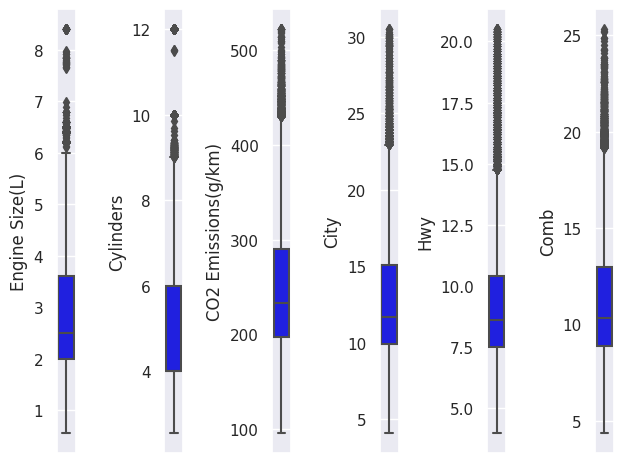

In [ ]:
nums = num_feat.columns
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=train_copy[nums[i]], color='blue', orient='v')
    plt.tight_layout()

Dari boxplot, bisa dilihat bahwa kotak biru agak melenceng dari bagian tengah. Ini menunjukkan distribusi yang agak skewed.

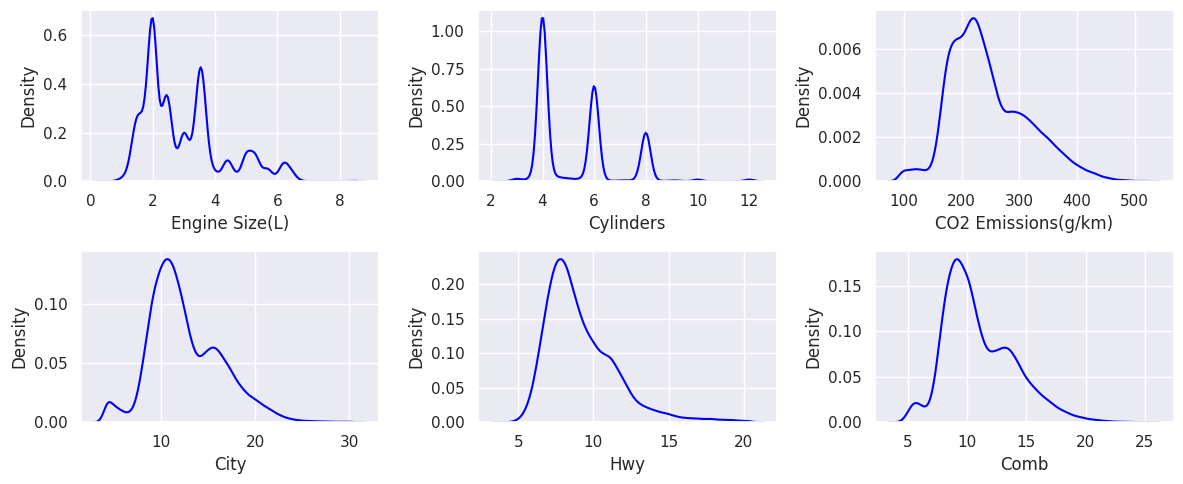

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums)//2, i+1)
    sns.kdeplot(train_copy[nums[i]], color='blue')
    plt.tight_layout()

Bisa kita lihat, terbukti bahwa distribusi kolom CO2, City, Hwy, dan Comb agak skewed kanan.

<Axes: >

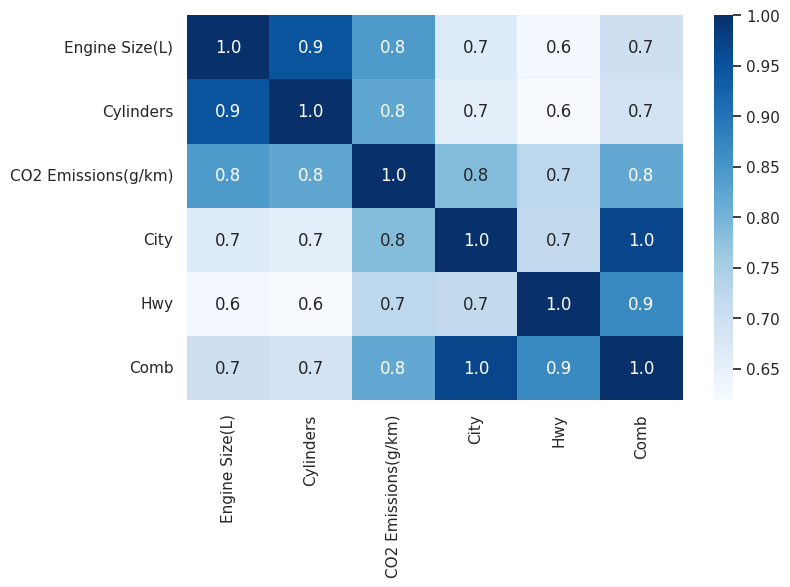

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(num_feat.corr(), cmap = 'Blues', annot= True, fmt='.1f')

Bisa kita lihat bahwa kolom-kolom numerical memiliki korelasi yang cukup tinggi terhadap target. Sehingga tidak perlu dilakukan feature engineering yang signifikan.

#### **Mengecek Distribusi Kolom**

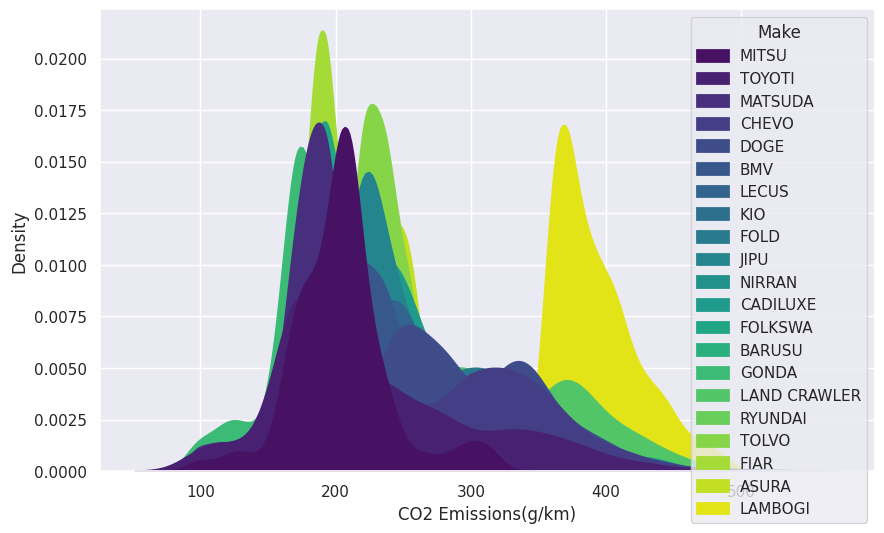

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=train_copy,
    x="CO2 Emissions(g/km)",
    hue="Make",
    fill=True,
    common_norm=False,
    palette="viridis",
    levels=5,
    linewidths=2,
    alpha=1,
)
plt.show()

LAMBOGI menjadi merek yang paling banyak menghasilkan emisi besar (>= 350) dan sisanya banyak terdistribusi pada angka 170--230.

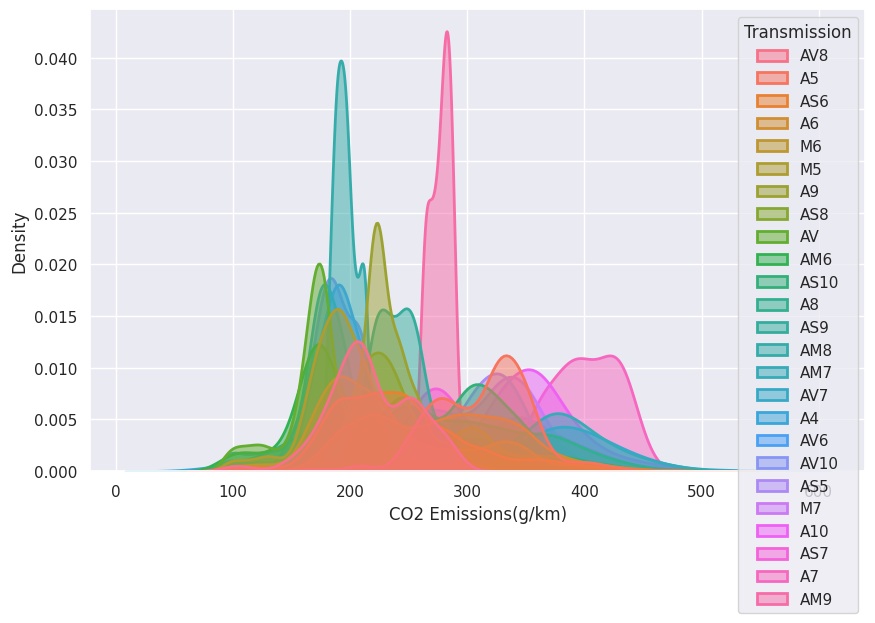

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=train_copy,
    x="CO2 Emissions(g/km)",
    hue="Transmission",
    fill=True,
    common_norm=False,
    palette="husl",
    levels=1,
    linewidths=2,
    alpha=0.5,
)
plt.show()

Transmission terlihat tidak banyak pola, tetapi AV8 cenderung memiliki rentang nilai yang sempit.

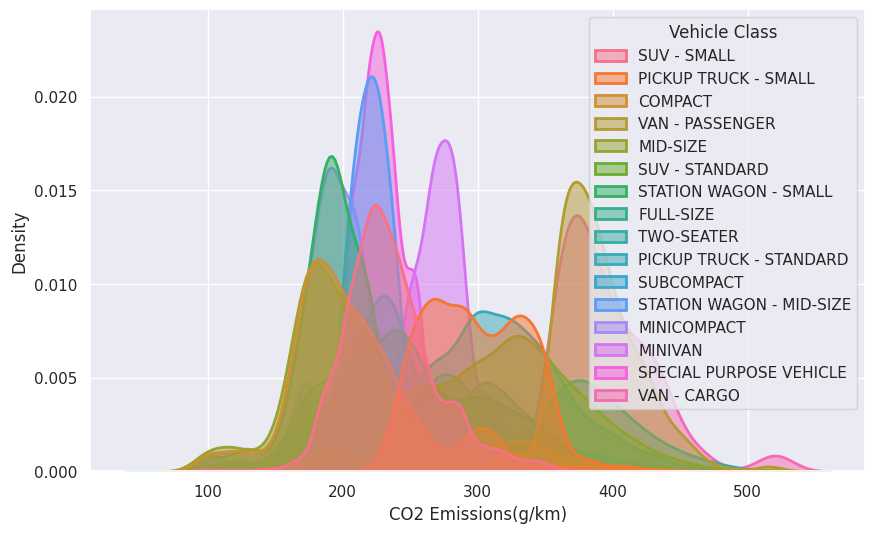

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_copy, x='CO2 Emissions(g/km)', hue='Vehicle Class', fill=True, common_norm=False, palette='husl',
            levels=10, linewidths=2, alpha=0.5)
plt.show()

Mobil dengan vehicle class VAN cenderung memiliki emisi yang besar dibanding yan lain.

## **Test**

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23545 entries, 54938 to 78482
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Make                   23545 non-null  object
 1   Vehicle Class          23326 non-null  object
 2   Engine Size(L)         22913 non-null  object
 3   Cylinders              23039 non-null  object
 4   Transmission           23382 non-null  object
 5   Fuel Type              23324 non-null  object
 6   Fuel Consumption City  22861 non-null  object
 7   Fuel Consumption Hwy   22824 non-null  object
 8   Fuel Consumption Comb  22857 non-null  object
dtypes: object(9)
memory usage: 1.8+ MB


In [ ]:
for i in test:
  print(f'{i}: {test[i].isna().sum()}')

Make: 0
Vehicle Class: 219
Engine Size(L): 632
Cylinders: 506
Transmission: 163
Fuel Type: 221
Fuel Consumption City: 684
Fuel Consumption Hwy: 721
Fuel Consumption Comb: 688


**Kesimpulan**:\
Setelah melalui proses EDA pertama dan kedua, kami menemukan bahwa semua atribut terlihat penting karena memiliki nilai korelasi yang besar dan secara common sense atribut-atributnya memang memengaruhi nilai emisi karbondioksida. Selanjutnya, kita lakukan preprocessing kedua untuk meng-impute nilai-nilai yang kosong.

# **Preprocessing (2)**

In [ ]:
#5
# Fungsi untuk melakukan imputasi
imputer = IterativeImputer(max_iter=100)
def feature_imputation(X:pd.DataFrame, test:bool=False) -> pd.DataFrame:
  df = X.copy()
  if not test:
    df = imputer.fit_transform(X)
  if test:
    df = imputer.transform(X)
  df = pd.DataFrame(df, columns=X.columns)
  return df

#6
# Fungsi menguantifikasi kolom dengan tujuan agar bisa diproses oleh model
def one_hot_encoding(X:pd.DataFrame) -> pd.DataFrame:
  df = X.copy()
  col_to_encode = ['Vehicle Class','Transmission','Make','Fuel Type']
  df = pd.get_dummies(df, columns=col_to_encode)
  return df

### **Pipelining (2)**

In [ ]:
X_train = one_hot_encoding(feature_imputation(X_train))
X_test = one_hot_encoding(feature_imputation(X_test, True))

# **Modelling** 🛠

#### **Metrics**

In [ ]:
def rmse(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return rmse

def rmsetf(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return tf.sqrt(mse)

#### **Hyperparameter Tuning Using Optuna**

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1500, 2000),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.7),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e5),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'border_count': trial.suggest_int('border_count', 1, 255),

    }

    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, squared=False)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_rmse = study.best_value
print(f'Best Hyperparameters: {best_params}')
print(f'Best Root Mean Squared Error: {best_rmse}')

Hyperparameter di notebook hanya contoh untuk catboost. Untuk model lain, kami melakukan tuning di tempat lain.

#### **Stacking**

In [ ]:
### DeepLearning ###
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

def createModel(dropout=0):
    model = Sequential([
      Dense(300,activation='selu', kernel_initializer='lecun_normal',
          kernel_regularizer=keras.regularizers.l2(0.01),
          input_shape=[len(X_train.columns)]),
      Dense(150,activation='selu', kernel_initializer='lecun_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
      Dense(75,activation='selu', kernel_initializer='lecun_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
      Dense(30,activation='selu', kernel_initializer='lecun_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
      Dense(1, activation='selu'),
  ])
    optimizer = Nadam(lr=5, beta_1=0.9,beta_2=0.999)
    model.compile(loss=tf.keras.metrics.mean_squared_error,
              optimizer=optimizer,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

nn = KerasRegressor(build_fn=createModel(), epochs=500, batch_size=64, verbose=0, callbacks=callbacks_list)

### CatBoostRegressor ###
cb = CatBoostRegressor(
    **{
        "iterations": 715,
        "depth": 9,
        "learning_rate": 0.21685466614525384,
        "l2_leaf_reg": 46.80107916663932,
        "min_child_samples": 5,
        "border_count": 40,
    }
)

### LGBMRegressor ###
lgb = LGBMRegressor(
    **{
        "max_depth": 20,
        "lambda_l1": 0.00016628985509900782,
        "lambda_l2": 0.002837398285557587,
        "min_split_gain": 0.7577793742601943,
        "min_child_weight": 9.419284482047434,
        "colsample_bytree": 0.7269574870557697,
        "subsample": 0.272828878529134,
        "reg_alpha": 6.174076387406154,
        "reg_lambda": 6.096821117413743,
        "n_estimators": 217,
    }
)

### HGBRegressor ###
hgb = HistGradientBoostingRegressor(
    **{
        "random_state": 42,
        "max_iter": 906,
        "learning_rate": 0.061763975927385646,
        "max_depth": 11,
        "min_samples_leaf": 10,
        "max_leaf_nodes": 79,
        "l2_regularization": 0.0011084209574226142,
        "max_bins": 48,
        "tol": 0.0007748920719902809,
    }
)

### XGBRegressor ###
xgb = XGBRegressor(
    **{
        "colsample_bytree": 0.5920623339546657,
        "learning_rate": 0.05655179773541492,
        "max_depth": 8,
        "n_estimators": 477,
        "gamma": 0.6651835678620678,
        "min_child_weight": 1.561555677120107,
        "alpha": 0.131264100671468,
        "lambda": 0.4116178861256159,
    }
)
### TReesRegressor ###
rnf = RandomForestRegressor()
ext = ExtraTreesRegressor()

### KNNRegressor ###
knn = KNeighborsRegressor()

### Ridge ###
final = Ridge()

### StackingRegressor ###
stacked_model = StackingRegressor(
    estimators=[
        ("cb", cb),
        ("lgb", lgb),
        ("rnf", rnf),
        ("xgb", xgb),
        ("nn", nn),
        ("hgb", hgb),
        ("ext", ext),
    ],
    final_estimator=final,
    n_jobs=-1,
)
stacked_model.fit(X_train, y_train)
y_pred = stacked_model.predict(X_test)
print(f"RMSE: {rmse(y_test, y_pred)}")

# **Final Submission** ✅

In [ ]:
%%time
sample = pd.read_csv('/content/sample_submission.csv', index_col='Id')
train = pd.read_csv("train.csv", index_col='Id')
test = pd.read_csv("test.csv", index_col='Id')
X, y = train.drop(["CO2 Emissions(g/km)"], axis=1), train["CO2 Emissions(g/km)"]
X = one_hot_encoding(feature_imputation(feature_dropping(label_encoding(feature_creation(change_impossible(X))))))
test = one_hot_encoding(feature_imputation(feature_dropping(label_encoding(feature_creation(change_impossible(test)), True)), True))

In [ ]:
%%time
stacked_model.fit(X, y)
sample['CO2 Emissions(g/km)'] = stacked_model.predict(test)
sns.kdeplot(data=sample, x='CO2 Emissions(g/km)', fill=True)

In [ ]:
#Save Model
import dill

# Example: Serialize an object
with open('CompVidia.pkl', 'wb') as f:
    dill.dump(stacked_model, f)

In [ ]:
if sample.isna().sum() == 0:
  sample.to_csv('submission.csv', index=True)